# Mod 5 Project - Sandy's Notebook

## Imports and Data Ingestion

In [1]:
#import libraries

import mod_5_project_helper as hp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score


#set environment - REMEMBER TO COPY OVER mod_5_project_helper.py

hp.set_environment()
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

#initiliase variables

%run variables.py

#import data

df = pd.read_csv("data.csv")

## Data Cleanup

In [2]:
df.drop_duplicates(inplace = True) #drop 10,728 duplicate rows

In [3]:
df.drop(index = 100000, axis = 0, inplace = True) #delete last blank row in the data set

In [4]:
df.drop(df[df["Current Loan Amount"] == 99999999].index, inplace = True) #delete 11484 rows where the loan amount is 99999999

In [5]:
df.dropna(subset = ['Credit Score'], inplace = True) #delete 19154 rows where Credit Score is missing

In [6]:
df.dropna(subset = ['Years in current job'], inplace = True) #delete 2564 rows where Years in current job is missing 

In [7]:
df["Years in current job"].replace(to_replace = "year.*", value = "",inplace = True, regex = True) #remove 'years' or 'year' from string

In [8]:
df.drop(df[df["Home Ownership"] == "HaveMortgage"].index, inplace = True) #delete 120 rows with "HaveMortgage" as meaning isn't clear

In [9]:
df.dropna(subset = ['Months since last delinquent'], inplace = True) #delete 30,000 rows where data is missing 

In [10]:
df.drop(columns = "Maximum Open Credit", inplace = True) #delete Maximum Open Credit columns as some of these numbers are huge e.g. 798255370.0

In [11]:
df = hp.drop_column_keyword_search(df, ["Loan ID", "Customer ID"]) #delete features 'Loan ID' and 'Customer ID' as they don't add anything

In [12]:
df = df.fillna(df.median()) #fill remaining values with 

In [13]:
#rename and consolidate categorical variables for purpose

df["Purpose"].replace({
              "Business Loan": "business_loan",
              "Medical Bills": "medical bills",
              "Educational Expenses": "educational_expenses",
              "Buy House": "buy_house",
              "Buy a Car": "buy_a_car",
              "Debt Consolidation": "debt_consolidation",
              "Home Improvements": "home_improvements",
              "Take a Trip": "take_a_trip",
              "vacation": "take_a_trip",
              "Major Purchase": "other",
              "Other": "other", 
              "renewable_energy": "home_improvements",
              "small_business": "business_loan",
              "moving": "home_improvements",
              "major_purchase": "major_purchase",
              "wedding": "wedding"
              }, inplace=True)

In [14]:
#rename categorical variables for Home Ownership

df["Home Ownership"].replace({
              "Home Mortgage": "mortgage",
              "Rent": "rent",
              "Own Home": "own_home",
              }, inplace=True)

In [15]:
#rename categorical variables for Term

df["Term"].replace({
              "Long Term": "long_term",
              "Short Term": "short_term",
              }, inplace=True)

In [16]:
#rename categorical variables for Loan Status

df["Loan Status"].replace({
              "Fully Paid": "fully_paid",
              "Charged Off": "default",
              }, inplace=True)

In [17]:
#rename columns to make the dataset easier to work with using . notation

df.columns = ['loan_status',
              'loan_amount',
              'term',
              'credit_score',
              'annual_income',
              'years_in_current_job',
              'home_ownership',
              'loan_purpose',
              'monthly_debt',
              'years_of_credit_history',
              'months_since_last_delinquent',
              'number_of_open_accounts',
              'number_of_credit_problems',
              'current_credit_balance',
              'bankruptcies',
              'tax_liens']

In [18]:
df.reset_index(inplace = True); #reset index
df.drop(columns = "index", inplace = True) #remove extra index columns as not needed
df['loan_status_binary_value'] = np.where(df["loan_status"] == "fully_paid",1,0) #add a binary columns for loan_status with 1 = "fully_paid" and 0 = "default"

## Cleaned Dataset Information

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   26401 non-null  object 
 1   loan_amount                   26401 non-null  float64
 2   term                          26401 non-null  object 
 3   credit_score                  26401 non-null  float64
 4   annual_income                 26401 non-null  float64
 5   years_in_current_job          26401 non-null  object 
 6   home_ownership                26401 non-null  object 
 7   loan_purpose                  26401 non-null  object 
 8   monthly_debt                  26401 non-null  float64
 9   years_of_credit_history       26401 non-null  float64
 10  months_since_last_delinquent  26401 non-null  float64
 11  number_of_open_accounts       26401 non-null  float64
 12  number_of_credit_problems     26401 non-null  float64
 13  c

In [20]:
df.shape

(26401, 17)

In [21]:
df.head()

,loan_status,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens,loan_status_binary_value
0,fully_paid,217646.0,short_term,730.0,1184194.0,< 1,mortgage,debt_consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,1.0,0.0,1
1,fully_paid,548746.0,short_term,678.0,2559110.0,2,rent,debt_consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,0.0,0.0,1
2,fully_paid,234124.0,short_term,727.0,693234.0,10+,rent,debt_consolidation,14211.24,24.7,46.0,10.0,1.0,28291.0,1.0,0.0,1
3,fully_paid,666204.0,long_term,723.0,1821967.0,10+,mortgage,debt_consolidation,17612.24,22.0,34.0,15.0,0.0,813694.0,0.0,0.0,1
4,default,317108.0,long_term,687.0,1133274.0,8,rent,debt_consolidation,9632.81,17.4,53.0,4.0,0.0,60287.0,0.0,0.0,0


In [112]:
df.groupby(df.loan_status).count()

,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens,loan_status_binary_value
loan_status,,,,,,,,,,,,,,,,
default,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479
fully_paid,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922


## Train, test split, sampling and K-folds

In [22]:
#define X and y columns

X = df.drop(columns = ["loan_status", "loan_status_binary_value"])
y = df.loan_status_binary_value

In [23]:
#define train, validation and test data 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [24]:
#make a dataframe of categorical variables - training data

X_train_categorical = pd.concat([X_train.term, 
                                 X_train.years_in_current_job, 
                                 X_train.home_ownership, 
                                 X_train.loan_purpose], 
                                 axis = 1) 

In [25]:
#make a dataframe of continous variables - training data

X_train_continuous = pd.concat([X_train.loan_amount, 
                                X_train.credit_score, 
                                X_train.annual_income, 
                                X_train.monthly_debt, 
                                X_train.years_of_credit_history,
                                X_train.months_since_last_delinquent,
                                X_train.number_of_open_accounts,
                                X_train.current_credit_balance,
                                X_train.bankruptcies,
                                X_train.tax_liens], 
                                axis = 1)

In [26]:
#one hot encode categorical variables - training data
#for everything but decision trees we should do drop_first = True
X_train_one_hot_encoded = pd.get_dummies(X_train_categorical)

In [27]:
#stitch the one hot encoded dataframe back together - training data

X_train_all_numbers = pd.concat([X_train_continuous, X_train_one_hot_encoded], axis = 1)

In [28]:
#make a dataframe of categorical variables - validation data

X_val_categorical = pd.concat([X_val.term, 
                               X_val.years_in_current_job, 
                               X_val.home_ownership, 
                               X_val.loan_purpose], 
                               axis = 1) 

In [29]:
#make a dataframe of continous variables - validation data

X_val_continuous = pd.concat([X_val.loan_amount, 
                              X_val.credit_score, 
                              X_val.annual_income, 
                              X_val.monthly_debt, 
                              X_val.years_of_credit_history,
                              X_val.months_since_last_delinquent,
                              X_val.number_of_open_accounts,
                              X_val.current_credit_balance,
                              X_val.bankruptcies,
                              X_val.tax_liens], 
                              axis = 1)

In [30]:
#one hot encode categorical variables - validation data
#for everything but decision trees we should do drop_first = True
X_val_one_hot_encoded = pd.get_dummies(X_val_categorical)

In [31]:
#stitch the one hot encoded dataframe back together - validation data

X_val_all_numbers = pd.concat([X_val_continuous, X_val_one_hot_encoded], axis = 1)

In [32]:
#use SMOTE to resample training data

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all_numbers, y_train) 

In [33]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42) #initialise cross validation object

In [34]:
#export data for CSVs for ease

X_train_resampled.to_csv("X_train.csv")
X_val_all_numbers.to_csv("X_val.csv")
y_train_resampled.to_csv("y_train.csv")
y_val.to_csv("y_val.csv")

In [47]:
X_.head()

,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
3747,268730.0,short_term,729.0,603402.0,< 1,mortgage,debt_consolidation,14833.87,13.9,76.0,10.0,0.0,211299.0,0.0,0.0
4276,267564.0,short_term,708.0,1078364.0,10+,own_home,home_improvements,4124.71,12.8,56.0,4.0,0.0,41154.0,0.0,0.0
18108,179454.0,short_term,701.0,1311114.0,10+,rent,debt_consolidation,16716.77,18.2,26.0,10.0,1.0,78603.0,1.0,0.0
13083,472494.0,long_term,656.0,1690525.0,10+,rent,debt_consolidation,29865.91,26.4,21.0,12.0,0.0,174496.0,0.0,0.0
14957,755458.0,short_term,686.0,1584486.0,10+,rent,debt_consolidation,19541.88,22.5,35.0,7.0,0.0,298167.0,0.0,0.0


## Decision Trees

In [69]:
#instantiate tree classifier object

tree_clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 20, random_state = 42)

In [70]:
tree_clf.fit(X_train_all_numbers, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [71]:
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [72]:
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [73]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [78]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')

train: 0.79 test: 0.68


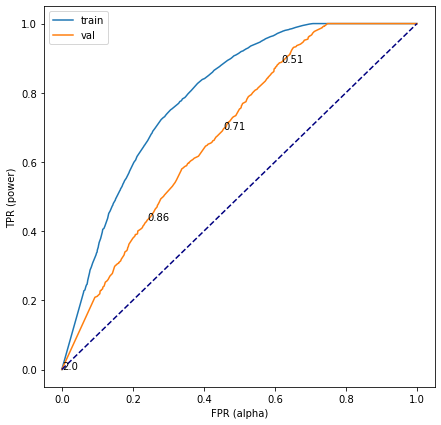

In [74]:
scores(tree_clf,X_train_resampled,X_val_all_numbers,y_train_resampled,y_val)
roc_plot(tree_clf,X_train_resampled,y_train_resampled,X_val_all_numbers,y_val)



train: 0.74 test: 0.72
{'max_depth': 10, 'min_samples_leaf': 500}


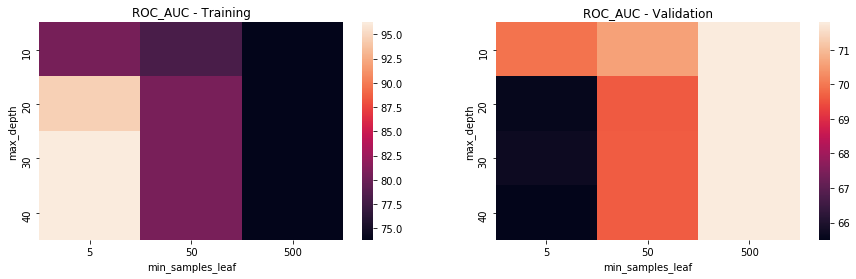

In [91]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.74 test: 0.72


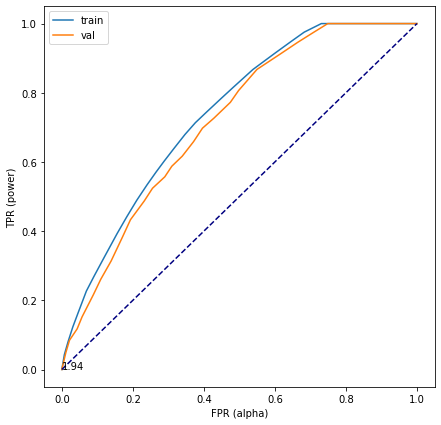

In [85]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.73 test: 0.71
{'max_depth': 10, 'min_samples_leaf': 700}


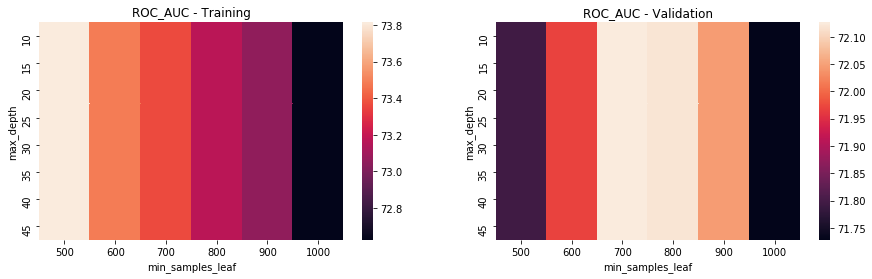

In [92]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(10,50,5),'min_samples_leaf':[500, 600, 700, 800, 900, 1000]}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.73 test: 0.71


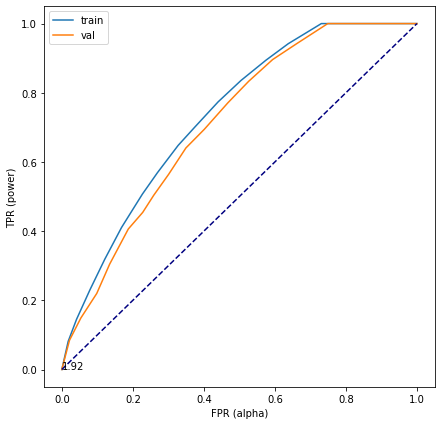

In [87]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.73 test: 0.71
{'max_depth': 7, 'min_samples_leaf': 770}


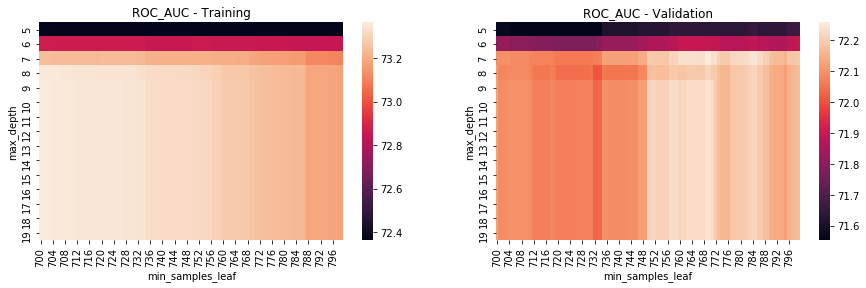

In [98]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(5,20),'min_samples_leaf':range(700,800)}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.73 test: 0.71


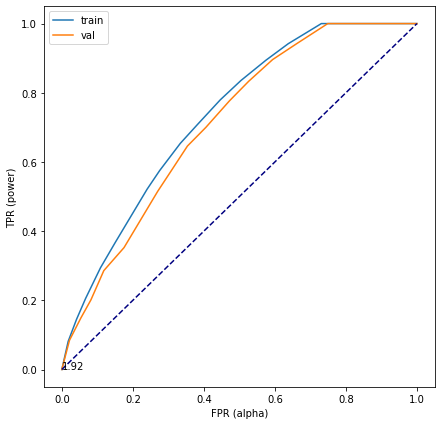

In [97]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

## Random Forests

In [99]:
forest_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42)

In [103]:
forest_clf.fit(X_train_all_numbers,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

train: 0.74 test: 0.73


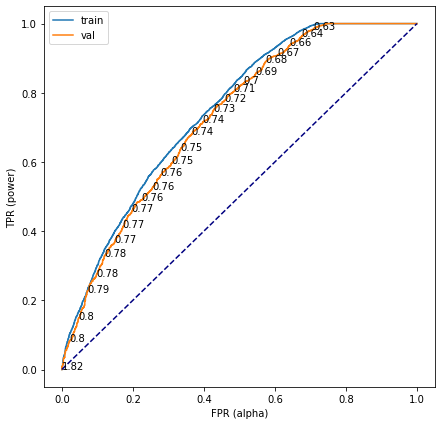

In [104]:
scores(forest_clf,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(forest_clf,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.74 test: 0.73
{'max_depth': 10, 'min_samples_leaf': 50}


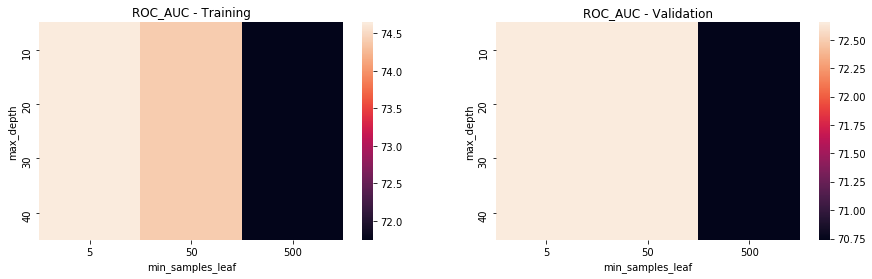

In [107]:
param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(forest_clf,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.74 test: 0.73


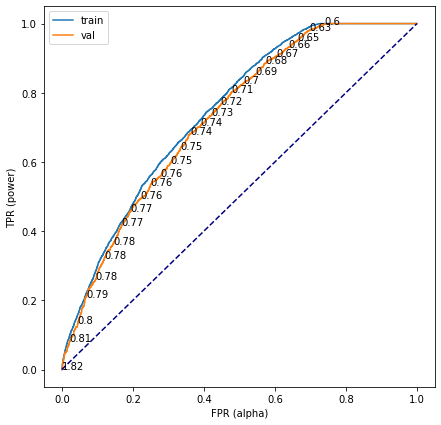

In [109]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.74 test: 0.73
{'max_depth': 9, 'min_samples_leaf': 31}


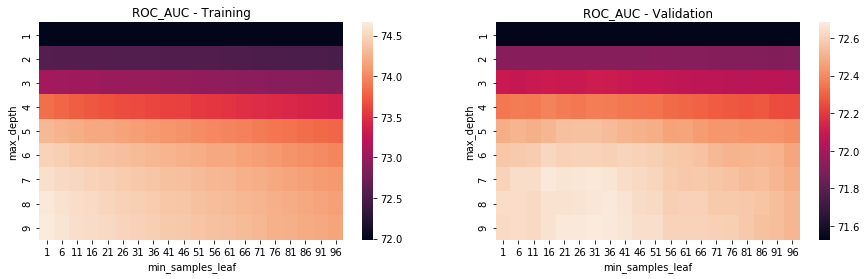

In [110]:
param_grid = {'max_depth':range(1,10),'min_samples_leaf':range(1,100,5)}

opt_model = GridSearchCV(forest_clf,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.74 test: 0.73


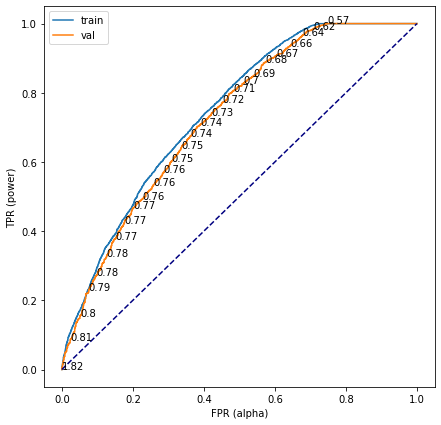

In [111]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)